# Overview
Tons of datasets by block through the census [here](https://data.census.gov/cedsci/table?q=United%20States&g=0500000US26163%241000000)

For the population used here, search DECENNIALSF12010.P10

# Status 
Some anomalies. 1/3 of blocks have 0 population. 2/3 of block ids with calls are null when joining on block_id between 911 calls and population data. previous work in [census_blocks](./census_blocks.ipynb) has shown call block ids to be good, so must be something funky with the census one. There are tons of other census data sets though, this is just the first I grabbed

Also, using floats instead of pd.Int64Dtype for block ids because pandas coerces it to something else when you group on it if it's pd.Int64Dtype()

In [162]:
import geopandas as gpd
from util_detroit import kml_to_gpd, csv_with_x_y_to_gpd
import re
import time

pd.options.display.max_rows = 300

# Only read in the columns we want
COLS_911 = [
    "calldescription",
    "call_timestamp",
    "block_id",
    "category",
    "officerinitiated",
    "priority",
    "oid",
    "longitude",
    "latitude",
]
TYPES_911 = [str, str, float, str, str, str, int, float, float]

In [92]:
# violent
close_proxy = ['ASSAULT','SHOTS','SHOOTING','CUTTING','HOLD UP','WEAP','ROBBERY ARMED','VIOLENT - ARMED','RAPE','STABBED','SHOT']
near_proxy = ['WITH WEAPON','DV','ABUSE','BREAKING AND ENTERING','BREAKING & ENTERING']
expr = re.compile('|'.join(close_proxy))

In [93]:
# use a generator function to select rows we want in chunks rather than loading everything into memory at once
generator = pd.read_csv(
    "calls_for_service_from_jimmy.csv",
    nrows=None,
    usecols=COLS_911,
    parse_dates=["call_timestamp"],
    chunksize=1e4,
    dtype=dict(zip(COLS_911, TYPES_911)),
)

call = (
    pd.concat(
        [x.loc[lambda x: x.calldescription.str.contains(expr)] for x in generator],
        ignore_index=True,
    )
)

call = gpd.GeoDataFrame(call,geometry=gpd.points_from_xy(call.longitude,call.latitude),crs='epsg:4327')

In [94]:
call.shape

(371176, 9)

In [176]:
block_count = (
    call.groupby("block_id")
    .oid.count()
    .rename("call_count")
    .sort_values(ascending=False)
)
block_count.head()
# representation_ratio = block_count/block_count.mean()

block_id
2.616354e+14    1819
2.616353e+14    1540
2.616350e+14    1281
2.616352e+14     924
2.616352e+14     851
Name: call_count, dtype: int64

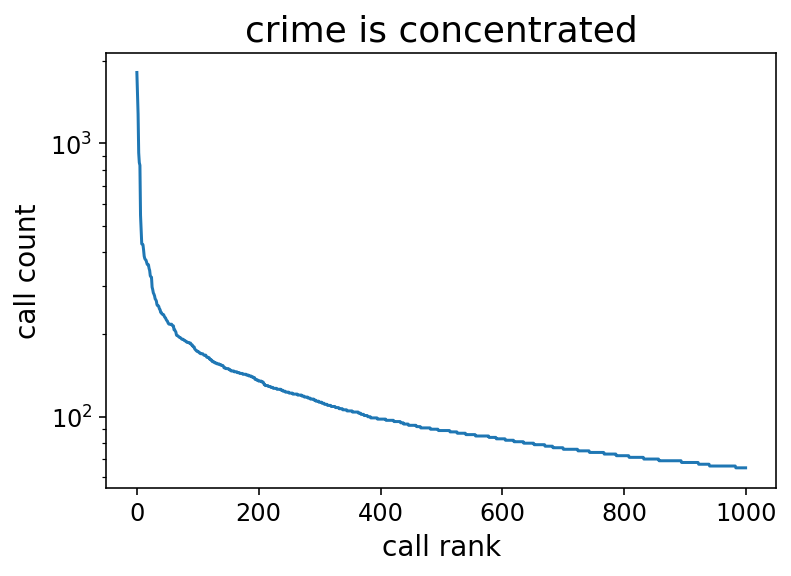

In [186]:
plt.plot(range(1000),block_count.head(1000))
_ = plt.gca().set(yscale='log',title='crime is concentrated',ylabel='call count',xlabel='call rank')

In [171]:
pop = pd.read_csv(
    "/Users/ahakso/Downloads/productDownload_2022-01-28T162855/DECENNIALSF12010.P10_data_with_overlays_2022-01-28T162836.csv",
    usecols=["GEO_ID", "P010001"],
    skiprows=[1],
).rename(columns={"GEO_ID": "block_id", "P010001": "population"})
pop = pop.assign(
    block_id=lambda x: x.block_id.str.split("US").apply(lambda s: s[1])
).astype({"block_id": float})

In [181]:
block_count.shape

(14581,)

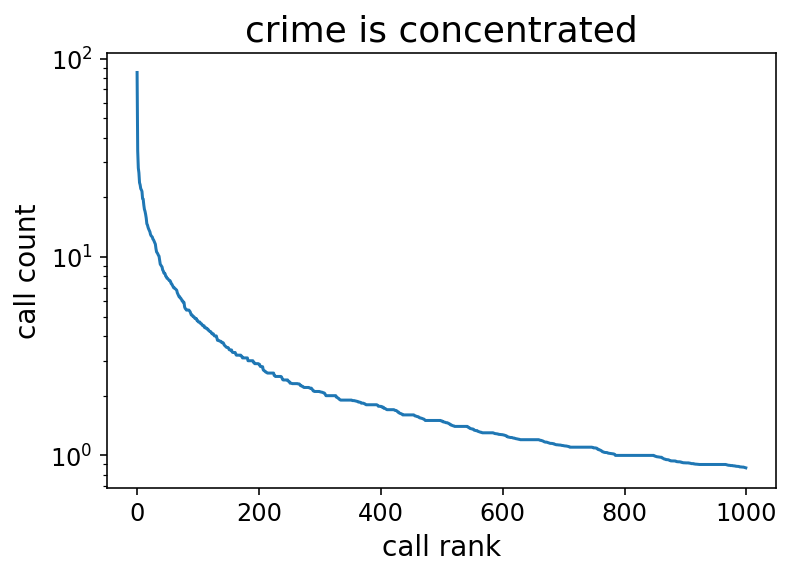

In [182]:
# losing 2/3 of call rows in this join for some reason
df = (
    pd.merge(block_count, pop, left_index=True, right_on="block_id")
#     addition is hack to dilute the impact of zero population zones
    .assign(calls_per_capita=lambda x: x.call_count / (x.population + 10))
    .sort_values("calls_per_capita", ascending=False)
)
plt.plot(range(1000), df.head(1000).calls_per_capita)
_ = plt.gca().set(
    yscale="log",
    title="crime is concentrated",
    ylabel="calls per capita",
    xlabel="call rank",
)